# Calculate EOS but every step re-run QE

In [1]:
import numpy as np
from ase.build import bulk
from ase.io.trajectory import Trajectory
#
from qepy.calculator import QEpyCalculator

In [2]:
qe_options = {
    '&control': {
        'calculation': "'scf'",
        'pseudo_dir': "'./'",
    },
    '&system': {
        'ibrav' : 0,
        'degauss': 0.005,
        'ecutwfc': 30,
        'occupations': "'smearing'"
    },
    'atomic_species': ['Al  26.98 Al.pbe-nl-kjpaw_psl.1.0.0.UPF'],
    'k_points automatic': ['10 10 10 1 1 1'],
}

!wget http://pseudopotentials.quantum-espresso.org/upf_files/Al.pbe-nl-kjpaw_psl.1.0.0.UPF

In [3]:
al = bulk('Al', 'fcc', a=4.05)

In [4]:
calc = QEpyCalculator(qe_options=qe_options, logfile=True, extrapolation=False)
# every step will write a new input file, and re-run QE
al.calc=calc

In [5]:
%%time
traj = Trajectory('tmp.traj', 'w')
cell = al.get_cell()
volumes = []
energies = []
for x in np.linspace(0.9, 1.1, 6):
    al.set_cell(cell * x, scale_atoms=True)
    vol = al.get_volume()
    ene = al.get_potential_energy()
    volumes.append(vol)
    energies.append(ene)
    traj.write(al)

CPU times: user 11.4 s, sys: 1.26 s, total: 12.6 s
Wall time: 11.7 s


76.98787048966183 GPa


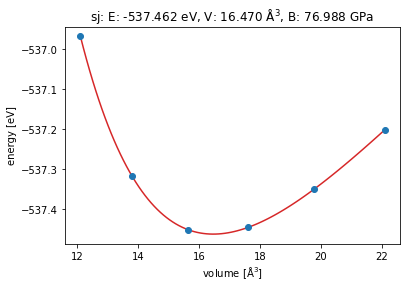

In [6]:
from ase.units import kJ
from ase.eos import EquationOfState
eos = EquationOfState(volumes, energies)
v0, e0, B = eos.fit()
print(B / kJ * 1.0e24, 'GPa')
eos.plot('tmp.eos.png');